## Part 2 Fitting a transit model

Some references
* Transits and occultations ([Winn 2014](https://arxiv.org/pdf/1001.2010.pdf))
* Analytic light curve model [Mandel & Agol (2002)](http://iopscience.iop.org/article/10.1086/345520/pdf)
* Properties of analytic transit light curve models [Pal 2008](https://arxiv.org/pdf/0805.2157.pdf)
* Limb darkening coefficients [(Kipping 2013)](https://arxiv.org/pdf/1308.0009.pdf)

In [1]:
#check python version
!python --version

Python 3.6.2 :: Continuum Analytics, Inc.


In [2]:
#check environment
import os
os.environ['CONDA_DEFAULT_ENV']

'py3'

## import data

In [3]:
from glob import glob

datadir = '.'
path    = os.path.join(datadir,'TRAPPIST-1*.csv')
file_list = glob(path)
file_list = sorted(file_list)
file_list

['./TRAPPIST-1_rad13_temp1.csv', './TRAPPIST-1_rad13_temp2.csv']

In [24]:
import pandas as pd
import numpy as np

#df means dataframe
df=pd.read_csv(file_list[0], delimiter=',', parse_dates=True)
df = df.drop(['Unnamed: 0'],axis=1)
#df = df.set_index('BJD(TDB)-2450000')
df.head(3)

,GJD-2450000,flux,err,airmass,sky,dx,dy
0,8062.876429,0.997372,0.004839,1.5601,1109.5,-0.027,-2.954
1,8062.877054,1.003590,0.004729,1.5560,979.8,-0.084,-2.454
2,8062.877679,1.003489,0.004581,1.5516,875.4,-0.130,-1.302


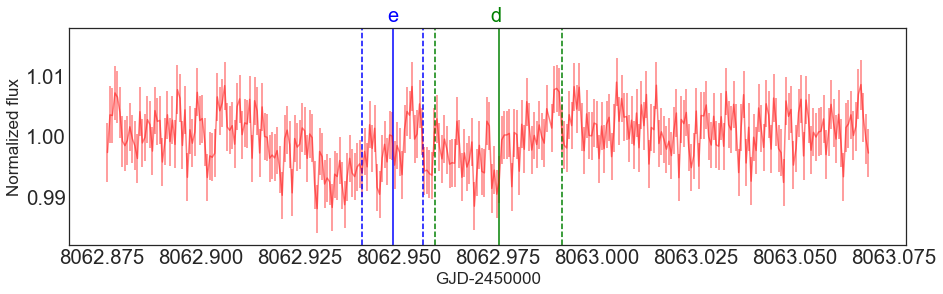

In [67]:
import matplotlib.pyplot as pl
%matplotlib inline


#styling
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 17})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize=20

fig,ax = plt.subplots(1,1,figsize=(15,4))

time = df["GJD-2450000"]
flux = df["flux"]
err  = df["err"]

ax.set_xlabel('GJD-2450000')
ax.set_ylabel('Normalized flux') 
plt.errorbar(time, flux, yerr=err, label="z", color="r", alpha=0.5) #alpha=touka ritsu

plt.ylim(0.982,1.018)
plt.vlines([8062.9485],0.98,1.02 , "blue")
plt.text(8062.9471, 1.019, "e",color='blue',fontsize='20')
plt.vlines([8062.97518],0.982,1.018 , "green")
plt.text(8062.973, 1.019, "d",color='green',fontsize='20')
plt.vlines([8062.9485-0.0076972],0.982,1.018 , "blue", linestyles='dashed')
plt.vlines([8062.9485+0.0076972],0.982,1.018 , "blue", linestyles='dashed')
plt.vlines([8062.97518-0.0159764],0.982,1.018 , "green", linestyles='dashed')
plt.vlines([8062.97518+0.0159764],0.982,1.018 , "green", linestyles='dashed')



## PyTransit

* [github link](https://github.com/hpparvi/PyTransit)

In [6]:
import pytransit

Don't forget to always check for documentation using (?). `MandelAgol` is a Python class (a collection of functions).

In [7]:
from pytransit import MandelAgol

MandelAgol?

From documentation, the basic syntax is

The important function of the `MandelAgol` class is `evaluate`. To use this, check documentation again.

In [8]:
#initialize model with default parameters: nothing inside ()
model = MandelAgol()

model.evaluate?

From, documentation, the basic syntax is

The parameters needed to evaluate the transit model are the following.

```
* t:     time
* k:     Rp/Rs: planet-star radius ratio (=k^2: transit depth)
* u1,u2: limb-darkening coefficients
* tc:    transit center
* P:     orbital period
* a_s:   a/Rs: scaled semi-major axis
* i:     inclination
* e:     eccentricity
* w:     argument of periastron
* c:     contamination factor
```

MY CONVENTION:
* _P  : published value
* P_  : computed value
* P_0 : initial guess

In [11]:
import numpy as np

#values come from S.Wang et al.(2017) 
_tc  = 8062.9449 
_P   = 6.099570 #pm 0.000091 (days)
_a   = 0.02818 #semimajor axis (AU)
_e   = 0.007 #pm 0.003
_Rp  = 0.918 #pm0.039 (R_earth)

#from M.Gillon et al.(2017)
_Rs  = 0.117 #pm 0.0036 (R_sun)
_b   = 0.12 #+0.11/-0.09
_inc = np.deg2rad(89.86) #+0.10/-0.12

In [12]:
from astropy import units as u

In [13]:
_Rp = 0.918
_Rs = 0.117*u.Rsun.to(u.Rearth)
k_ = _Rp/_Rs
k_

0.07193266328324543

In [14]:
_a = 0.02818
_Rs = 0.117*u.Rsun.to(u.au)
a_s_= _a/_Rs
a_s_

51.79150552817122

From the plot above, we can guess the transit center during the MuSCAT observation.

In [15]:
tc_0      = 8062.930

We've figured out most of the transit parameters needed to evaluate the Mandel-Agol model except the limb-darkening coefficients, `u1` and `u2`.

See notes on limb-darkening coefficients: [Espinoza & Jordan (2015)](https://arxiv.org/pdf/1503.07020.pdf)

See also equation 1 in ([Kipping 2013](https://arxiv.org/pdf/1308.0009.pdf)):
$$
\frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
$$
where $\mu=\cos \theta$ is the cosine of the angle between the line of sight and the emergent intensity.

NOTE: Please check the bounds of u1 and u2.

Guess: -1 < u1,u2 < 1

So naively, let's suppose values for u1 and u2, say:

In [16]:
u1_0, u2_0 = 0.1, 0.1

Now, let's evaluate the transit model for g-band using `MandelAgol().evaluate`:

In [17]:
model = MandelAgol()

time = df["GJD-2450000"]

flux_model = model.evaluate(time, k_, (u1_0,u2_0), tc_0, _P, a_s_, _inc)

Now, plot data and model together.

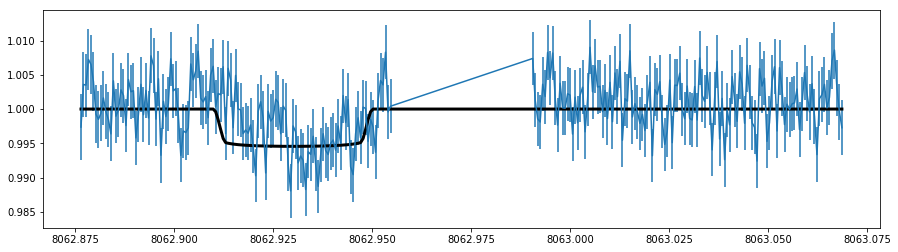

In [18]:
fig = plt.figure(figsize=(15,4))

time = df["GJD-2450000"]
flux = df["flux"]
err  = df["err"]

#plot data
plt.errorbar(time, flux, yerr=err)
#plot the analytic light curve
plt.plot(time, flux_model,'k-', lw=3)

## varying u1,u2

Let's do a simple exercise of varying u1 and u2 to see the effect on the shape of the transit model. Eventually, we will pick values of u1,u2 that fit the data by visual inspection.  

First, vary u1 and fix u2=0.1

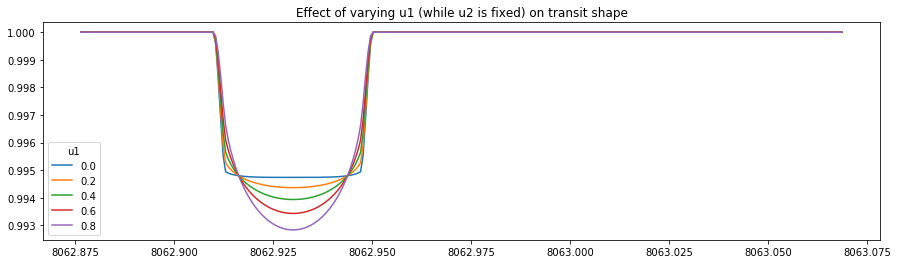

In [25]:
fig = plt.figure(figsize=(15,4))

#make a list of u1 from 0 to 1 in multiple of 0.2
u1_list = np.arange(0, 1, 0.2)
u2_0    = 0.1

for u in u1_list:
    flux_model = model.evaluate(time, k_, (u,u2_0), tc_0, _P, a_s_, _inc)
    plt.plot(time,flux_model,'-', label=u)
plt.title('Effect of varying u1 (while u2 is fixed) on transit shape')
plt.legend(title='u1')

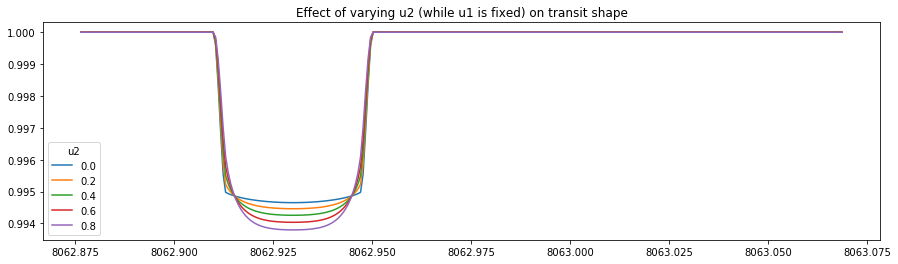

In [26]:
fig,ax = plt.subplots(1,1,figsize=(15,4))

#make a list of u1 from 0 to 1 in multiple of 0.2
u2_list = np.arange(0,1,0.2) #what if negative value?
u1_0    = 0.1

for u in u2_list:
    flux_model = model.evaluate(time, k_, (u1_0,u), tc_0, _P, a_s_, _inc)
    ax.plot(time,flux_model,'-',label=u)
plt.title('Effect of varying u2 (while u1 is fixed) on transit shape')
plt.legend(title='u2')

By visual inspection, it seems good the use the following values:

In [27]:
u1_0,u2_0 = 0.8, 0.1

As shown above, it is evident that the effect of u1 (coefficient of the linear term) is greater than the effect of u2 (coefficient of quadratic term) on the resulting shape of the transit model.

$$
\frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
$$

Because we will evaluate the model many times later, let's make a function that takes a list of transit parameters.

Everyone is encouraged to write code that is very clear. Take for example the function below.

In [28]:
from pytransit import MandelAgol

def transit_model(parameters, period, time, model=MandelAgol()):
    '''
    Compute flux using the Mandel-Agol model:
    
    \frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
    
    `parameters` must be a list containing:
    * k  : Rp/Rs: planet-star radius ratio
    * u1 : limb-darkening coefficient (for the linear term)
    * u2 : limb-darkening coefficient (for the quadratice term)
    * tc : transit center
    * a_s: a/Rs: scaled semi-major axis
    * inc: inclination
    '''
    #unpack each parameter
    k,u1,u2,tc,a_s,inc = parameters
    
    #evaluate the model
    m = model.evaluate(time, k, (u1,u2), tc, period, a_s, inc)
    
    return m

Now, let's use this function to plot the model given the updated the value of u1,u2 we chose from above.

In [23]:
transit_params  = [k_,u1_0,u2_0,tc_0,a_s_,_inc]

flux_model = transit_model(transit_params, _P, time)

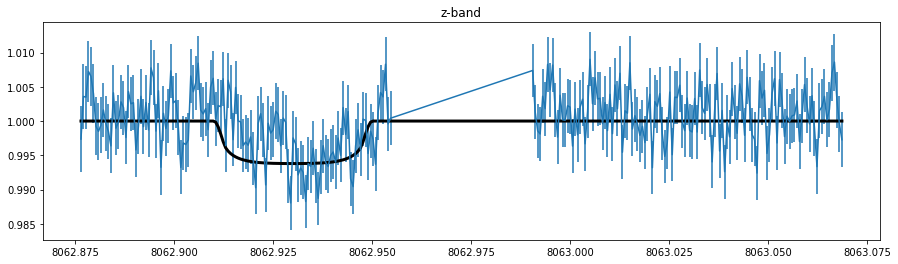

In [33]:
fig = plt.figure(figsize=(15,4))

time = df["GJD-2450000"]
flux = df["flux"]
err  = df["err"]

#plot data
plt.errorbar(time, flux, yerr=err)
#plot the analytic light curve
plt.plot(time, flux_model, 'k-', lw=3)
plt.title('z-band')

Not bad!

## Limb-darkening coefficients based on stellar parameters

* See [Claret (2012)](https://www.aanda.org/articles/aa/pdf/2012/10/aa19849-12.pdf)

John created a Python package called [limbdark](https://github.com/john-livingston/limbdark) available in github that is used to interpolate values of limb darkening coefficients (with uncertainties) using stellar properties (with uncertainties): 
* Teff: effective temperature
* log g: surface gravity
* [Fe/H]: metallicity

given the [table](http://adsabs.harvard.edu/abs/2012yCat..35460014C) of linear limb darkening coefficients from Claret+2012.

As noted in his code:

```
Uses table downloaded from:
http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/529/A75/table-af
band must be one of: B C H I J K Kp R S1 S2 S3 S4 U V b g* i* r* u u* v y z*

log g below came from adopted model 11 (Table 11) of Hartmann+2014
```

In [34]:
import limbdark as ld

ld.claret??

Let's use the published values available in [exoplanets.org](http://exoplanets.org/detail/HAT-P-44_b).

In [35]:
#parameter and uncertainty
teff, uteff = 2559,  50 #from M.Gillon(2017)
logg, ulogg = 4.39, 0.03 #from Exoplanets Data Explorer
feh, ufeh   = 0.04,  0.08 #from M.Gillon(2017)

In [36]:
import limbdark as ld

u1_,u1err, u2_,u2err = ld.claret('z*', teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))

print('z-band: u1={}+-{:.3f}, u2={}+={:.3f}'.format(u1_,u1err, u2_,u2err))

z-band: u1=0.3733+-0.076, u2=0.5481+=0.130


In [37]:
transit_params  = [k_,u1_,u2_,tc_0,a_s_,_inc]

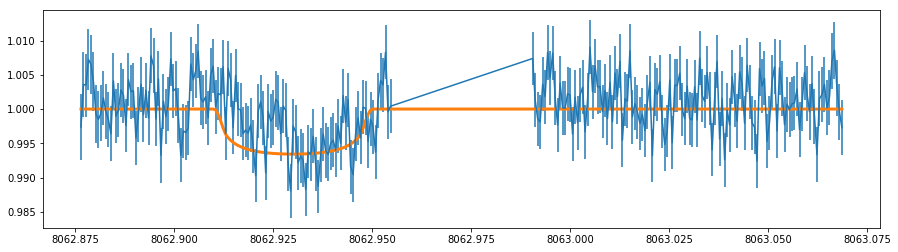

In [38]:
fig = plt.figure(figsize=(15,4))

time = df["GJD-2450000"]
flux = df["flux"]
err  = df["err"]

flux_model = transit_model(transit_params, _P, time)

plt.errorbar(time,flux,yerr=err)
plt.plot(time,flux_model,lw=3)

## Fine tuning the transit model

Note on sampling limb-darkening coefficients in q-space [(Kipping 2013)](https://arxiv.org/pdf/1308.0009.pdf)

To quote the paper:
```
By re-parametrizing the LDCs from a set θ of θ = {u1, u2} to θ = {q1, q2}, one can fit for quadratic LDCs
in such a way that the joint prior distribution is uniform and exclusively samples physically plausible solutions
```

In [39]:
def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

Use the functions above to convert u1,u2 to q1,q2:

In [40]:
u_to_q(u1_,u2_)

(0.84897796000000003, 0.20257217278055134)

## Now let's rewrite the function `transit_model_q` which expects that the transit parameter vector `parameters` contains `q1,q2` instead of `u1,u2`.

Equally important, we will use impact parameter `b` instead of inclination `inc` for reasons that will be important later. Because `MandelAgol().evaluate` expects `u1,u2` and `inc` as input, we should add lines inside `transit_model_q` that computes `u1,u2`from `q1,q2` and `inc` from `b` and `a_s`.

In [45]:
def transit_model_q(parameters, period, time):
    '''
    Compute flux using the Mandel-Agol model:
    
    \frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
    
    `parameters` must be a list containing:
    * k  : Rp/Rs: planet-star radius ratio
    * q1 : limb-darkening coefficient (for the linear term)
    * q2 : limb-darkening coefficient (for the quadratice term)
    * tc : transit center
    * a_s: a/Rs: scaled semi-major axis
    * b  : impact parameter
    
    model input assumes limb-darkening coefficients
    parameterization in q-space as in Kipping 2013
    
    also converts impact parameter (b) to inclination
    assuming eccentricity is 0
    '''
    k,q1,q2,tc,a,b = parameters
    
    #compute inclination
    inc   = np.arccos(b/a)
    #convert q to u
    u1,u2 = q_to_u(q1, q2)
    #evaluate the model
    m = model.evaluate(time, k, (u1,u2), tc, period, a, inc)
    
    return m

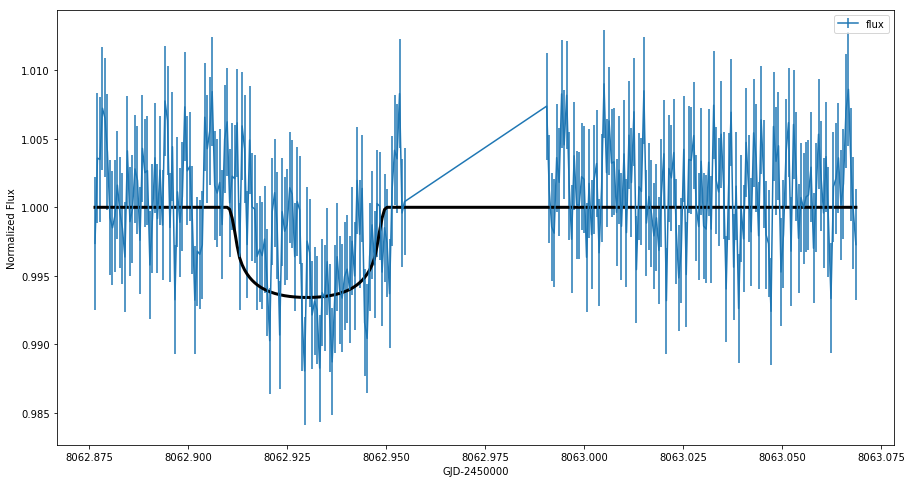

In [46]:
fig,ax = plt.subplots(1,1,figsize=(15,8))

time = df["GJD-2450000"]
flux = df["flux"]
err  = df["err"]

plt.errorbar(time, flux, yerr=err) 
    
q1_,q2_ = u_to_q(u1_,u2_)
    
transit_params  = [k_,q1_,q2_,tc_0,a_s_,_b]
flux_model      = transit_model_q(transit_params, _P, time)
    
ax.plot(time, flux_model, 'k-', lw=3)
ax.legend()

ax.set_ylabel('Normalized Flux')
ax.set_xlabel('GJD-2450000')

![img](images/q.jpg)

## varying q1,q2

Now, let's do the same exercise as above, this time varying q1,q2.

In [36]:
#for g-band
q1_,q2_ = u_to_q(ldc_g[0],ldc_g[1])

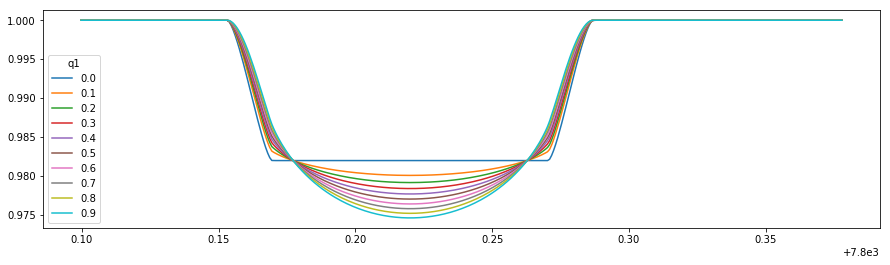

In [37]:
#vary q1 and keep q2 fixed

fig,ax = pl.subplots(1,1,figsize=(15,4))

q1_list = np.arange(0,1,0.1)

for q in q1_list:
    params = [k_,q,q2_,tc_0,_a_s,_b]
    flux_model = transit_model_q(params, _P, time)
    ax.plot(time,flux_model,'-', label=q)
pl.legend(title='q1')

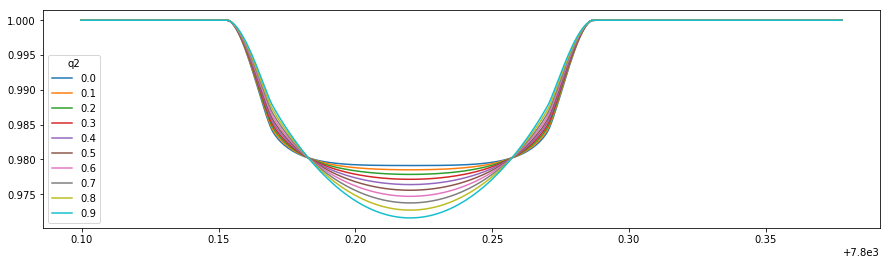

In [38]:
#vary q12 and keep q1 fixed

fig,ax = pl.subplots(1,1,figsize=(15,4))

q2_list = np.arange(0,1,0.1)

for q in q2_list:
    params = [k_,q1_,q,tc_0,_a_s,_b]
    flux_model = transit_model_q(params, _P, time)
    ax.plot(time,flux_model,'-', label=q)
pl.legend(title='q2')

# Appendix

## Limb darkening

### q <---> u mapping

Let's see the values of u that are physically realistic.

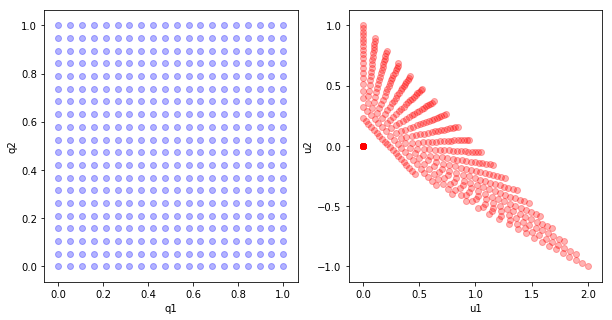

In [39]:
fig, ax = pl.subplots(1,2, figsize=(10,5))

q1_list = np.linspace(0, 1, 20)
q2_list = np.linspace(0, 1, 20)

for q1 in q1_list:
    for q2 in q2_list:
        ax[0].scatter(q1,q2,color='b',alpha=0.3)
        u1,u2=q_to_u(q1,q2)
        ax[1].scatter(u1,u2,color='r',alpha=0.3)

ax[0].set_xlabel('q1')
ax[0].set_ylabel('q2')

ax[1].set_xlabel('u1')
ax[1].set_ylabel('u2')

### Physics of limb-darkening 

Limb-darkening effect can be visualized using the black body curves.

In [40]:
import numpy as np
from matplotlib import pylab as pl
from astropy import constants as c
%matplotlib inline


#remove raised error = overflow in numpy
np.seterr(all='ignore')
#to reset
#np.seterr(all='warn', over='raise')

h = 6.626e-34 #c.h
s = 3.0e+8    #c.c
k = 1.38e-23  #c.k_B

def planck(lambda_, T):
    a = 2.0*h*s**2
    b = h*s/(lambda_*k*T)
    return a/ ((lambda_**5) * (np.exp(b) - 1.0))

Bandpasses:
```
B C H I J K Kp R S1 S2 S3 S4 U V b g* i* r* u u* v y z*
```

T=4000.0 (g): I=3.75e+14
T=4000.0 (z): I=3.87e+14
T=5000.0 (g): I=1.69e+15
T=5000.0 (z): I=9.07e+14


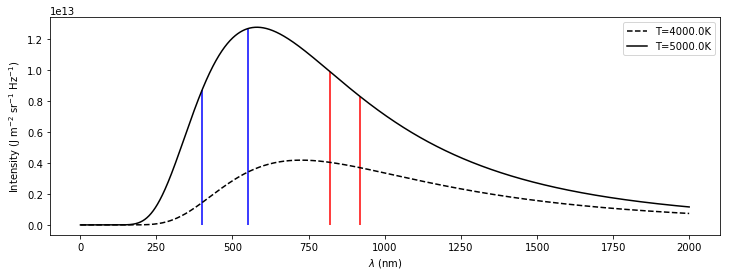

In [41]:
fig, ax =pl.subplots(1,1,figsize=(12,4))

# generate x-axis in increments from 1nm to 3 micrometer in 1 nm increments
# starting at 1 nm to avoid wav = 0, which would result in division by zero.
wavelengths = np.arange(1e-9, 2e-6, 1e-9) 

#MuSCAT g,r,z filters in meter
g=[400e-9, 550e-9]
r=[550e-9, 700e-9] 
z=[820e-9, 920e-9] 

# intensity at T=4000K, 5000K, 6000K, 7000K
temperature = [4.0e3,5.0e3]

I = [] #intensity
I_band = []
bandpasses = [g,z]
for T in temperature:
    Ii = planck(wavelengths, T)
    I.append(Ii)
    for bp,text in zip(bandpasses,['g','z']):
        #integrate within bandpass to get total intensity
        width=np.arange(bp[0],bp[1],1e-9)
        total_I = sum(planck(width, T))
        I_band.append(total_I)
        print('T={} ({}): I={:.2e}'.format(T,text,total_I))

#plot blackbody (hot=photosphere, cold=limb)
lstyle = ['--','-']
for n,(j,ls) in enumerate(zip(I,lstyle)):
    ax.plot(wavelengths*1e9, j, ls=ls, color='k', label='T={}K'.format(temperature[n]))  

#plot bandpass
factor = 1e9
colors='b,r'.split(',')
for bp,c in zip(bandpasses,colors):
    #compute upper blackbody curve limits
    y_left = planck(bp[0], temperature[-1])
    y_right= planck(bp[1], temperature[-1])
    #plot band pass
    ax.vlines(bp[0]*factor, 0, y_left, color=c) 
    ax.vlines(bp[1]*factor, 0, y_right, color=c)
    
ax.set_ylabel('Intensity (J m$^{-2}$ sr$^{-1}$ Hz$^{-1}$)')
ax.set_xlabel('$\lambda$ (nm)')
#ax.set_ylim([0,4e13])
pl.legend()

In [42]:
#gband: photosphere/limb
I_band[2]/I_band[0]

4.5142764373612501

In [43]:
#zband: photosphere/limb
I_band[3]/I_band[1]

2.3426699705643803

The upper black body corresponds to the solar disk (hotter) and the lower corresponds to the limb (cooler). 

As we go towards longer wavelengths (red), the ratio of the intensities (area bounded by each bandpasses) approaches 1, i.e. limb darkening effect is negligible in the infrared and more pronoounced in the optical. Thus, we expect to see the shape of z-band flatter than g-band. 

### Uncertainty propagation

In [44]:
import numpy as np
from uncertainties import ufloat 
from astropy import units as u

P   = ufloat(4.301219,0.000019)
Rp  = ufloat(1.523,0.442)   #+0.442-0.226

Rs_jup  = 0.949*u.Rsun.to(u.Rjup)
Rs_jup_u= 0.08*u.Rsun.to(u.Rjup) #+0.08/-0.037
Rs  = ufloat(Rs_jup,Rs_jup_u)

t14 = ufloat(0.1302,0.0008) 
b   = ufloat(0.172,0.079)   #+0.079/-0.074     
a_s = ufloat(11.52,0.74)
k   = ufloat(np.sqrt(0.01804),np.sqrt(0.00027)) 
inc = ufloat(np.deg2rad(89.10),np.deg2rad(0.4))

In [45]:
k

0.13431306712304653+/-0.016431676725154984

In [46]:
#uncertainty in k
Rp/Rs

0.16491840817134548+/-0.04984031996673391

In [47]:
from uncertainties.umath import *

num   = ((k + 1)**2 - b**2)**(0.5)
denom = sin(inc) * sin(t14 * np.pi / P)

#uncertainty in a_s
num/denom

11.809211418629959+/-0.22844457501225646

## Useful equations

In [48]:
def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    a/Rs: scaled semi-major axis
    
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

_t14  = 0.13020
_b    = 0.172
a_s_  = scaled_a(_P, _t14, k_, i=_inc, impact_param=_b)
a_s_

11.80879179358181

In [49]:
def inclination(a, b, e=None, w=None):
    """
    Winn 2014 ("Transits and Occultations"), eq. 7
    """
    # if e is None and w is None:
    #     return np.arccos(b / a)
    # elif e is not None and w is not None:
    #     return np.arccos(b / a * (1 + e * np.sin(w)) / (1 - e**2))
    # else:
    #     return np.nan
    return np.arccos(b / a)
    

def t14_circ(p, a, k, b):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    i = inclination(a, b)
    alpha = np.sqrt( (1 + k)**2 - b**2 )
    return (p / np.pi) * np.arcsin( alpha / np.sin(i) / a )


def t23_circ(p, a, k, b):
    """
    Winn 2014 ("Transits and Occultations"), eq. 15
    """
    i = inclination(a, b)
    alpha = np.sqrt( (1 - k)**2 - b**2 )
    return (p / np.pi) * np.arcsin( alpha / np.sin(i) / a )


def tau_circ(p, a, k, b):
    """
    Winn 2014 ("Transits and Occultations"), eq. 18
    """
    return p / np.pi / a * k / np.sqrt(1 - b**2)


def tshape_approx(a, k, b):
    """
    Seager & Mallen-Ornelas 2003, eq. 15
    """
    i = inclination(a, b)
    alpha = (1 - k)**2 - b**2
    beta = (1 + k)**2 - b**2
    return np.sqrt( alpha / beta )


def max_k(tshape):
    """
    Seager & Mallen-Ornelas 2003, eq. 21
    """
    return (1 - tshape) / (1 + tshape)


def scaled_a(p, t14, k, i=np.pi/2, b=0):
    numer = np.sqrt( (k + 1)**2 - b**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)


def rhostar(p, a):
    """
    Eq.4 of http://arxiv.org/pdf/1311.1170v3.pdf. Assumes circular orbit.
    """
    p = p * u.d
    gpcc = u.g / u.cm ** 3
    rho_mks = 3 * np.pi / c.G / p ** 2 * a ** 3
    return rho_mks.to(gpcc)


def logg(rho, r):
    r = (r * u.R_sun).cgs
    gpcc = u.g / u.cm ** 3
    rho *= gpcc
    g = 4 * np.pi / 3 * c.G.cgs * rho * r
    return np.log10(g.value)


def rho(logg, r):
    r = (r * u.R_sun).cgs
    g = 10 ** logg * u.cm / u.s ** 2
    rho = 3 * g / (r * c.G.cgs * 4 * np.pi)
    return rho


def sample_rhostar(a_samples, p):
    """
    Given samples of the scaled semi-major axis and the period,
    compute samples of rhostar
    """
    rho = []
    n = int(1e4) if len(a_samples) > 1e4 else len(a_samples)
    for a in a_samples[np.random.randint(len(a_samples), size=n)]:
        rho.append(rhostar(p, a).value)
    return np.array(rho)


def sample_logg(rho_samples, rstar, urstar):
    """
    Given samples of the stellar density and the stellar radius
    (and its uncertainty), compute samples of logg
    """
    rs = rstar + urstar * np.random.randn(len(rho_samples))
    idx = rs > 0
    return logg(rho_samples[idx], rs[idx])


def sample_ephem(orb, tc_samples, n=10000):
    tc_samples = np.array(tc_samples).T
    ephem = []
    for tc_s in tc_samples[np.random.randint(tc_samples.shape[0], size=n)]:
        ephem.append(stats.simple_ols(orb, tc_s))
    return np.array(ephem)